## This Notebook - Goals - FOR EDINA 

**Aim:** <br>
The purpose of this Notebook is to introduce the user to <code>ObsPy</code>, a Python framework for processing seismological data. It illustrates how to access, visualize and process seismic data from a large number of networks.

**Target audience:** <br>
This Notebook is primarily aimed at users interested in geophysics. It is especially aimed at academics teaching or students learning about seismology and seismic signal processing.
 
**Motivation:** <br>
The motivation behind creating this exemplar is to promote Noteable by showing the large variety of libraries that are pre-installed in the Geospatial Notebook. It can also serve as a tutorial or guide for academics on how to introduce digital seismic data analysis to their students.

**Noteable features to exploit:** <br>
This Notebook focuses on one specific library included within the Geospatial Notebook called <code>ObsPy</code>. It also utilizes <code>ipywidgets</code>, a framework to provide eventful python objects that have a representation in the browser, to make the tutorial interactive. 

**How are the features exploited:** <br>
The Notebook makes use of the various modules within <code>ObsPy</code>, that can be utilized for different aspects of seismic data processing. This is interwoven with the interactiveness of widgets in order to briefly illustrate how some common variables can be changed to change the code.
<hr>

# Accessing seismic data using Obspy

<code>ObsPy</code> is a Python package aimed at processing seismological data, including parsers for common file formats, clients to access data centers and seismological signal processing routines. The different clients hold station, instrument and event information, as well as waveform data. Station information encompasses an inventory of network metadata (code, description,...), station metadata (code, latitude, longitude, elevation, start- and endtime of recordings,...) and channel metadata (location code, latitude, longitude, elevation, dip, azimuth, instrument response, sample rate,...). Amongst other things, it can be used to plot the location of the stations within a network or to plot the instrument response of a seismograph at a particular station. Event information is stored in a catalogue of seismic events, such as natural or human-induced earthquakes. Its metadata includes the origin (location, depth, time), magnitudes (magnitude types), picks, focal mechanisms. Waveform data is stored in a Stream object containing multiple Trace objects with the actual waveform data as a timeseries and the metadata of the station information (network, station, channel, location, sampling rate,...).

Available clients included in <code>ObsPy</code>:
- [fdsn](https://www.fdsn.org/webservices/)
- [arclink](https://docs.obspy.org/packages/obspy.clients.arclink.html)
- [iris](https://service.iris.edu/irisws/)
- [neic](https://github.com/usgs/edgecwb/wiki)
- [filesystem](https://docs.obspy.org/packages/obspy.clients.filesystem.html)
- [seedlink](https://docs.obspy.org/packages/obspy.clients.seedlink.html#module-obspy.clients.seedlink)
- [nrl](http://ds.iris.edu/NRL/)
- [seishub](https://docs.obspy.org/master/packages/obspy.clients.seishub.html)
- [syngine](https://ds.iris.edu/ds/products/syngine/)
- [earthworm](http://www.earthwormcentral.org/)


This Notebook gives an introduction to the wide range of uses of <code>ObsPy</code>. The documentation for <code>ObsPy</code> can be found [here](https://docs.obspy.org/_downloads/ObsPyTutorial.pdf). Further links for seismologists on special use cases aimed at processing seismic data can be found [here](http://seismo-live.org/).

**Notebook contents:**
- Importing the necessary libraries
- List of providers included in the FDSN client
- Accessing the earthquake catalogue
- Accessing the station metadata in a network
- Plotting waveform data as seismograms (using widgets)
- Filtering seismograms (using widgets)
- Plotting the intrument response of a seismograph at a specific station
- Retrieving phase arrivals
- Plotting travel time curves 
- Plotting ray paths within the Earth 

In [1]:
# Import general libraries
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Import modules from obspy
import obspy
from obspy.clients.fdsn import RoutingClient, Client
from obspy.clients.fdsn.header import URL_MAPPINGS
from obspy import read, read_inventory, UTCDateTime 
from obspy.taup import TauPyModel, plot_travel_times
from obspy.taup.tau import plot_ray_paths 

# Import widget library
from ipywidgets import widgets, interact, interactive 
from IPython.display import display

## Hide warning messages
import warnings
warnings.filterwarnings('ignore')

## Providers within the FDSN client
The International Federation of Digital Seismograph Networks implements a large number of data centres such as USGS, NOA and IRIS. This section lists all the available data centres. In further sections, only USGS and IRIS is used, but the method to access the other data centres is the same so the code could be adapted to fit them. The data centres do not necessarily offer all three types of data (waveform, station and event information), so if you are unsure which provider to use, you can use a routing client instead of explicitly specifying the client. 

In [2]:
# Print all the providers included in the FDSN client
for key in sorted(URL_MAPPINGS.keys()):
    print("{0:<11} {1}".format(key,  URL_MAPPINGS[key]))

# Use routing client
routing_client = RoutingClient("iris-federator")

BGR         http://eida.bgr.de
EMSC        http://www.seismicportal.eu
ETH         http://eida.ethz.ch
GEONET      http://service.geonet.org.nz
GFZ         http://geofon.gfz-potsdam.de
ICGC        http://ws.icgc.cat
INGV        http://webservices.ingv.it
IPGP        http://ws.ipgp.fr
IRIS        http://service.iris.edu
ISC         http://isc-mirror.iris.washington.edu
KNMI        http://rdsa.knmi.nl
KOERI       http://eida.koeri.boun.edu.tr
LMU         http://erde.geophysik.uni-muenchen.de
NCEDC       http://service.ncedc.org
NIEP        http://eida-sc3.infp.ro
NOA         http://eida.gein.noa.gr
ODC         http://www.orfeus-eu.org
ORFEUS      http://www.orfeus-eu.org
RASPISHAKE  http://fdsnws.raspberryshakedata.com
RESIF       http://ws.resif.fr
SCEDC       http://service.scedc.caltech.edu
TEXNET      http://rtserve.beg.utexas.edu
UIB-NORSAR  http://eida.geo.uib.no
USGS        http://earthquake.usgs.gov
USP         http://sismo.iag.usp.br


## Access to the earthquake catalogue
One of the FDSN providers which offer event metadata is USGS. Its earthquake catalogue is accessible through <code>ObsPy</code> and the data can be used to filter events through time, location and magnitude using <code>client.get_events()</code> method. The following example searches the catalogue for any earthquakes  with at least a magnitude of 8 in December 2004. There are two earthquakes found, the locations of which can be plotted on a world map using <code>catalogue.plot()</code>. The size and colour of the data points are scaled by the magnitude  and the origin depth respectively.

In [3]:
#ONLY WORKS IN BETA - DELETE ONCE LIVE IS UPDATED

# Specify the webserver within the FDSN client
client = Client('USGS')

# Specify the time frame to search for earthquake events in
starttime = UTCDateTime('2004-12-01')
endtime = UTCDateTime('2004-12-31')

# Find earthquake in catalogue with a chosen minimum magnitude
cat = client.get_events(starttime=starttime, endtime=endtime, minmagnitude=8)
print(cat)
# Note: spatial constraints can also be specified within client.get_events()

# Plot the location of the earthquakes in the catalogue
cat.plot(title='Earthquakes in December 2004', method='cartopy')
plt.show()

2 Event(s) in Catalog:
2004-12-26T00:58:53.450000Z |  +3.295,  +95.982 | 9.1 mw | manual
2004-12-23T14:59:04.410000Z | -49.312, +161.345 | 8.1 mwc | manual


ImportError: cannot import name 'dedent' from 'matplotlib.cbook' (/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py)

## Access to the station metadata within a seismic network
One of the FDSN providers which offer station metadata is IRIS. Its station data is accessible through <code>ObsPy</code> and the data can be used to filter stations through time, location and network using <code>client.get_stations()</code> method. IRIS will be used in all further sections where a client is called. There are many different networks available within IRIS, a full list can be found [here](http://www.fdsn.org/networks/). In this section, the Global Seismograph Network of IRIS/USGS (network code:'IU') is used as it has a large number of station across the world. IU is one of the most commonly used networks, but other local networks might be more suitable for you depending on the kind of data you are interested in. The individual networks have a collection of stations which they acquire their data from. The IU network has list of stations, their station codes can be found [here](http://www.fdsn.org/networks/detail/IU/).

The selected stations are stored in an inventory, which can be plotted to show the location of the stations around the world using <code>inventory.plot()</code>.

In [4]:
#ONLY WORKS IN BETA - DELETE ONCE LIVE IS UPDATED

# Specify the webserver within the FDSN client
client2 = Client('IRIS')

# Specify the time frame to search for station data in
starttime = UTCDateTime('2004-12-26T00:00:00')
endtime = UTCDateTime('2004-12-27T12:00:00')

# Retrieve station data for all stations within the network 'Global Seismograph Network - IRIS/USGS' abbreviated 'IU'
ins2 = client2.get_stations(starttime=starttime, endtime=endtime,
                            network='IU')

# Plot the location of all the stations in the IU network
ins2.plot(method='cartopy')

# Retrieve station data for a station 'BILL' in Bilibino, Russia within the IU network
ins = client2.get_stations(starttime=starttime, endtime=endtime, 
                           network='IU', station='BILL')

# Plot the location of the BILL station in the IU network
ins.plot(method='cartopy')
print(ins, ins2)
plt.show()

ImportError: cannot import name 'dedent' from 'matplotlib.cbook' (/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py)

## Plotting waveform data - seismograms

As explained above, there are different seismic networks which are available to use and they all have a list of stations within the network. To access the actual waveform data, however, it is not enough to specify the network and the station. You also need to define which channel and location code you are interested in. The channels and location codes for the individual stations within IU can be found [here](http://service.iris.edu/irisws/fedcatalog/1/query?net=IU&format=text&includeoverlaps=true&nodata=404).

Channel codes are usually made up of a set of three letters. The first letter refers to the  general sampling rate and the response band of the instrument such as S for short-period instrument. The second letter specifies the type of instrument that is used, such as H for a high-gain seismometer. The third letter indicates the orientation of the sensor measurement and is an axis of a 3D orthogonal coordinate system, such as Z,N,E for Vertical, North-South, East-West. The full list of abbreviations for the channel code can be found [here](https://ds.iris.edu/ds/nodes/dmc/data/formats/seed-channel-naming/).

The location code is a 2 character code used to uniquely identify different data streams at a single station. These IDs are commonly used to logically separate multiple instruments or sensor sets at a single station.

The hierarchy of station data is: network $\rightarrow$ station $\rightarrow$ location code and channel.

In this section the waveform data from one station located at Bilibino, Russia (BILL) or Cathedral Cave, Missouri, USA (CCM) is extracted at the time of the 26.12.2004 Sumatra earthquake (from the catalogue in the previous section in this Notebook). Data for all three orientations (ZNE) from both short- (S) and long-period (L) high-gain seismometers were retrieved and plotted on a seismogram.

The arrivals of different phases (waves originating from the earthquake) to the selected station can be detected from the seismogram if the reader knows the characteristics of the different elastic waves and phases (such as their polarisation). The most straightforward one to identify is the P-wave, as it is the first arrival on the seismogram, often most visible in the vertical component of the seismogram. All you need is to identify the time of the first real motion that is not background static. For BILL, this happens at 01:10:57, indicating that the P-wave took 12min 5sec to reach the station from the earthquake origin. This knowledge is often used to identify the location of the earthquake if data is available from at least 3 stations (in this case, however, we already knew where it happened).

A widget was used to make this template more concise, the station can be chosen from the dropdown list.

In [5]:
# Specify the reference time
t = UTCDateTime('2004-12-26T00:58:53.450')

# Define function to plot the seismograms
def waveforms_for_station(station_select):
    if station_select == 'Bilibino, Russia (BILL)':
        # Retrieve waveform data for all three orientations (ZNE) for a short-period high-gain seismometer (SH)
        s_one = client2.get_waveforms('IU', # Network
                                      'BILL', # Station
                                      '10', # Location
                                      'SH?', # Channel - S=short-period, H=high-gain, ?=all directions (ZNE)
                                      t+720, # Starttime
                                      t + 780) # Endtime 
        # Retrieve waveform data for all three orientations (ZNE) for a long-period high-gain seismometer (LH)
        l_one = client2.get_waveforms('IU', 'BILL', '00', 'LH?', t+690, t + 1200)
        # Plot seismograms
        s_one.plot(show=True, size=(900, 350))
        l_one.plot(show=True, size=(900, 350))
    else:
        # Retrieve waveform data for all three orientations (ZNE) for a short-period high-gain seismometer (SH)
        s_two = client2.get_waveforms('IU', 'CCM', '10', 'SH?', t+960, t + 1020)
        # Retrieve waveform data for all three orientations (ZNE) for a long-period high-gain seismometer (LH)
        l_two = client2.get_waveforms('IU', 'CCM', '00', 'LH?', t+960, t + 1230)
        # Plot seismograms
        s_two.plot(show=True, size=(900, 350))
        l_two.plot(show=True, size=(900, 350))

# Create dropdown list widget to choose which station to retrieve data from
stations = ['Bilibino, Russia (BILL)', 'Cathedral Cave, Missouri, USA (CCM)']
interactive_plot = interactive(waveforms_for_station, 
                               station_select=widgets.Dropdown(options=stations, 
                                                               value='Bilibino, Russia (BILL)',
                                                               description='Choose station:', 
                                                               style={'description_width': 'initial'}, 
                                                               disabled=False))
interactive_plot.layout.height = '750px'
interactive_plot


interactive(children=(Dropdown(description='Choose station:', options=('Bilibino, Russia (BILL)', 'Cathedral C…

## Filtering seismograms
The seismograms illustrated above can also be filtered using one of the four filtering options available in <code>ObsPy</code>. Certain frequency ranges can be filtered out in order to improve the signal to noise ratio. Of course, for the result to be sensible, you need more insight into filtering, but this section shows how the filters can be created in a Notebook. A widget was added where the type of filter and the corresponding frequency range can be selected. The first cell filters the data from the short-period instrument, whereas the second cell filters the long-period seismometer.

There are 4 filtering options:
- <code>highpass</code> - filters out frequencies above a certain frequency (given by maximum frequency in widget)
- <code>lowpass</code> - filters out frequencies below a certain frequency (given by minimum frequency in widget)
- <code>bandpass</code> - filters out frequencies outside of a specified frequency range (given by both minimum and maximum frequency in widget)
- <code>bandstop</code> - filters out frequencies within a specified frequency range (given by both minimum and maximum frequency in widget)

More information and more advanced examples of filtering can be found [here](https://krischer.github.io/seismo_live_build/html/Signal%20Processing/filter_basics_solution_wrapper.html) and [here](https://docs.obspy.org/packages/autogen/obspy.signal.filter.html#module-obspy.signal.filter).

*Note: If bandpass or bandstop is selected, make sure the maximum and minimum frequency are not equal. If this happens with the former, it filters out all the data, if it happens with the latter it essentially does not filter the data at all.*

In [7]:
# Define function to filter the seismograms (short-period instrument)
def filtering(filter_select, max_freq, min_freq):
    station = ['BILL', 'CCM']
    shortperiod = ['s_one', 's_two']
    starttime1 = [720, 960]
    endtime1 = [780, 1020]
    for i in range(0,2):
        shortperiod[i] = client2.get_waveforms('IU', station[i], '10', 'SH?', t+starttime1[i], t + endtime1[i])
        st_filt = shortperiod[i].copy()
        # Cut out frequencies above a certain frequency if highpass is selected
        if filter_select == 'highpass':
            st_filt.filter(filter_select, freq=max_freq, 
                           corners=2, zerophase=True).plot(show=True, size=(900, 350))
        # Cut out frequencies below a certain frequency if lowpass is selected
        elif filter_select == 'lowpass':
            st_filt.filter(filter_select, freq=min_freq, 
                           corners=2, zerophase=True).plot(show=True, size=(900, 350))
        # Cut out frequencies outside or within a frequency range if bandpass or bandstop is selected respectively
        else:
            st_filt.filter(filter_select, freqmin=min_freq, freqmax=max_freq, 
                           corners=2, zerophase=True).plot(show=True, size=(900, 350))

# Create dropdown list widget to choose which option to use
filters = ['highpass', 'lowpass', 'bandpass', 'bandstop']
interactive_plot = interactive(filtering,
                               # Dropdown widget for the filter option
                               filter_select = widgets.Dropdown(options=filters, value='highpass',
                                                                description='Type of filter', 
                                                                style={'description_width': 'initial'},
                                                                disabled=False),
                               # Slider widget for maximum frequency
                               max_freq = widgets.FloatSlider(value=1, min=0.2, max=10, step=0.2, 
                                                              description='Max frequency', 
                                                              style={'description_width': 'initial'},
                                                              disabled=False),
                               # Slider widget for minimum frequency
                               min_freq = widgets.FloatSlider(value=1, min=0.2, max=10, step=0.2, 
                                                              description='Min frequency', 
                                                              style={'description_width': 'initial'},
                                                              disabled=False))
interactive_plot.layout.height = '800px'
interactive_plot

interactive(children=(Dropdown(description='Type of filter', options=('highpass', 'lowpass', 'bandpass', 'band…

In [8]:
# Define function to filter the seismograms (long-period instrument)
def filtering(filter_select, max_freq, min_freq):
    station = ['BILL', 'CCM']
    longperiod = ['l_one', 'l_two']
    starttime2 = [690, 960]
    endtime2 = [1200, 1230]
    for i in range(0,2):
        longperiod[i] = client2.get_waveforms('IU', station[i], '00', 'LH?', t+starttime2[i], t + endtime2[i])
        lt_filt = longperiod[i].copy()
        # Cut out frequencies above a certain frequency if highpass is selected
        if filter_select == 'highpass':
            lt_filt.filter(filter_select, freq=max_freq, 
                           corners=2, zerophase=True).plot(show=True, size=(900, 350))
        # Cut out frequencies below a certain frequency if lowpass is selected
        elif filter_select == 'lowpass':
            lt_filt.filter(filter_select, freq=min_freq, 
                           corners=2, zerophase=True).plot(show=True, size=(900, 350))
        # Cut out frequencies outside or within a frequency range if bandpass or bandstop is selected respectively
        else:
            lt_filt.filter(filter_select, freqmin=min_freq, freqmax=max_freq, 
                           corners=2, zerophase=True).plot(show=True, size=(900, 350))

# Create dropdown list widget to choose which option to use
filters = ['highpass', 'lowpass', 'bandpass', 'bandstop']
interactive_plot = interactive(filtering,
                               # Dropdown widget for the filter option
                               filter_select=widgets.Dropdown(options=filters, value='highpass',
                                                              description='Type of filter', 
                                                              style={'description_width': 'initial'},
                                                              disabled=False),
                               # Slider widget for maximum frequency
                               max_freq = widgets.FloatSlider(value=0.1, min=0.001, max=0.4, step=0.001, 
                                                              description='Max frequency', 
                                                              style={'description_width': 'initial'},
                                                              disabled=False),
                               # Slider widget for minimum frequency
                               min_freq = widgets.FloatSlider(value=0.1, min=0.001, max=0.4, step=0.001, 
                                                              description='Min frequency', 
                                                              style={'description_width': 'initial'},
                                                              disabled=False))
interactive_plot.layout.height = '800px'
interactive_plot

interactive(children=(Dropdown(description='Type of filter', options=('highpass', 'lowpass', 'bandpass', 'band…

## Instrument response
The instrument response describes how incoming data (in whatever the instrument measures) is transformed into what is finally stored in a file. Different types of seismometers respond differently to waves of a certain frequency. Short-period seismometers are more sensitive to high frequency waves so the amplitude seen on the seismograms will be considerably larger and more pronounced for a high frequency wave (such as P-waves) than for low frequency waves (such as surface waves). Long-period seismometers are pick up low frequency waves (such as surface waves) more than the high frequency waves (such as P-waves). This is all due to the physics of simple harmonic motion and resonance. Therefore, it is often useful to plot the instrument response (amplitude and phase delay) against the frequency spectrum.

The sampling rate $Δt$ of the instrument (the Nyquist frequency is $f_N=1/(2Δt)$ ) is shown as the dashed vertical line. The plot does not show frequencies higher than the Nyquist frequency (the vertical dashed line) as these frequencies do not exist in the data and thus have no physical meaning.

This section shows the instrument response of a vertically oriented, extremely short-period high-gain seismometer from a station in Jochberg, Germany in the BayernNetz network.

Network BW (BayernNetz)
	Station Count: None/None (Selected/Total)
	-- - --
	Access: UNKNOWN
	Contains:
		Stations (3):
			BW.RJOB (Jochberg, Bavaria, BW-Net) (3x)
		Channels (9):
			BW.RJOB..EHZ (3x), BW.RJOB..EHN (3x), BW.RJOB..EHE (3x) 
 Channel Response
	From M/S (Velocity in Meters per Second) to COUNTS (Digital Counts)
	Overall Sensitivity: 4e+08 defined at 2.000 Hz
	2 stages:
		Stage 1: PolesZerosResponseStage from M/S to V, gain: 400
		Stage 2: CoefficientsTypeResponseStage from V to COUNTS, gain: 1e+06


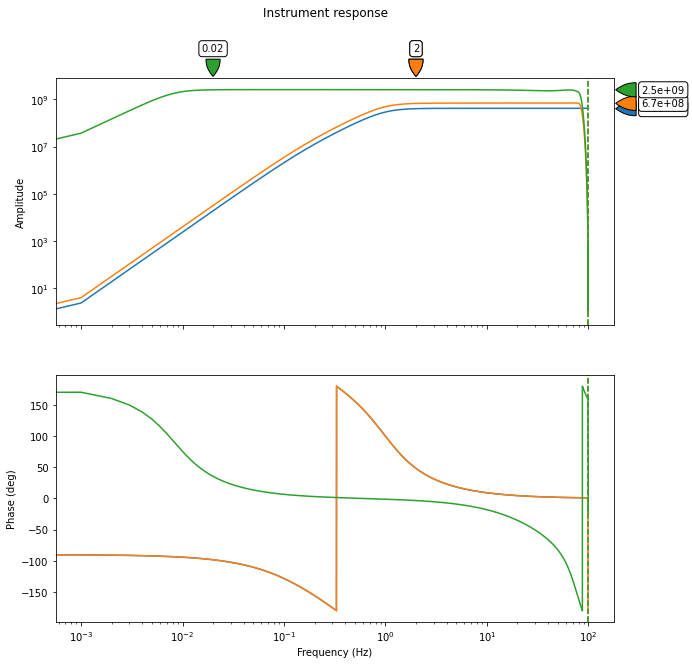

In [9]:
# Set figure size and axes
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,10))

# Customize plot
fig.suptitle('Instrument response')
ax1.set_ylabel('Amplitude')
ax2.set_ylabel('Phase (deg)')
ax2.set_xlabel('Frequency (Hz)')

# Plot instrument response
inv = read_inventory()
print(inv[1], '\n',  inv[1][0][0].response)
inv.plot_response(0.001, station='RJOB', channel='EHZ', output='VEL', plot_degrees=True, axes=[ax1, ax2])
plt.show()


## Phase arrivals and travel time curves
After an earthquake occurs, stations around the world pick up the seismic signals after a certain time dely. This delay depends on how far away the the station is located from the earthquake hypocentre (origin within the Earth) and the type of wave (phase) it is.

There are two kinds of waves: body and surface waves. The most basic body and surface waves are P- and S-waves, and Love and Rayleigh waves respectively. They all have characteristic wave speeds based on the material they are propagating in, however their relative speeds in the same medium stays the same, with P-waves being the fastest, then S-waves followed by Love and finally Rayleigh waves. However, due to internal diffractions, reflections and refractions within the Earth, these aren't the only phases see on the seismogram. There are all kinds of combinations of different wave types such as 'PS' (P-wave that converted into S-wave upon reflection) or reflected phases like 'PPP' (P-wave internally reflected off the surface) or refracted phases such as 'PKIKP' (P-wave refracted through the inner and outer core). This leads to a very complex order of phase arrivals. These can be visualised in travel time curves, where the travel time is plotted against the source-receiver distance using the <code>plot_travel_times()</code> method of the obspy.taup module. The module encompasses several different models of the Earth's structure, so the travel time mastercurve can be plotted for each model. These plots are often used to help determine the location of the earthquake since the travel time differences between phases are unique to the source-receiver distances. It can also explicitly print the travel time for the selected phases originating from a pre-determined source depth and source-receiver distance using <code>get_travel_times()</code>.

The full list of 1D velocity models within the <code>taup</code> module can be found [here](http://docs.obspy.org/packages/obspy.taup.html#module-obspy.taup).

In [10]:
# Select velocity model
model = TauPyModel(model='iasp91')

# Retrieve travel times for a list of phases - 2 options illustrated
arrivals = model.get_travel_times(source_depth_in_km = 30, # Depth the earthquake originated from
                                  distance_in_degree = 30, # Dstance from the epicentre of the earthquake
                                  phase_list = ['P', 'PS', 'S', 'PP', 'SS']) # List of phases
arrivals2 = model.get_ray_paths(source_depth_in_km = 30, 
                                distance_in_degree = 30, 
                                phase_list = ['P', 'PS', 'S', 'PP', 'SS'])
# Print arrival times of the phases
print(arrivals)
print('\n', arrivals2)

# Print ray characteristics (ray parameter, arrival time, angle of incidence)
arr = arrivals[0]
print('\nRay parameter:', arr.ray_param, '\nArrival time:', arr.time, '\nAngle of incidence:', arr.incident_angle)


11 arrivals
	P phase arrival at 365.891 seconds
	PP phase arrival at 423.055 seconds
	PP phase arrival at 423.111 seconds
	PP phase arrival at 423.446 seconds
	PP phase arrival at 433.835 seconds
	PP phase arrival at 433.970 seconds
	S phase arrival at 662.764 seconds
	PS phase arrival at 673.441 seconds
	SS phase arrival at 757.126 seconds
	SS phase arrival at 791.479 seconds
	SS phase arrival at 791.590 seconds

 11 arrivals
	P phase arrival at 365.891 seconds
	PP phase arrival at 423.055 seconds
	PP phase arrival at 423.111 seconds
	PP phase arrival at 423.446 seconds
	PP phase arrival at 433.835 seconds
	PP phase arrival at 433.970 seconds
	S phase arrival at 662.764 seconds
	PS phase arrival at 673.441 seconds
	SS phase arrival at 757.126 seconds
	SS phase arrival at 791.479 seconds
	SS phase arrival at 791.590 seconds

Ray parameter: 506.590947717 
Arrival time: 365.89059098 
Angle of incidence: 27.463780892


In [11]:
# Define function to plot travel time curves for a list of phases against distance (default model = 'iasp91')
def travel_times_mastercurve(model_select):
    # Set figure size and axes
    fig, ax = plt.subplots(figsize=(10, 10))
    # Customize plot
    ax.grid()
    ax.set_title('Phase travel time curves through the Earth')
    # Plot travel time curves for a list of phases against distance (default model = 'iasp91')
    plot_travel_times(source_depth=20, npoints = 80, model = model_select, 
                      phase_list=['P', 'S', 'PP', 'SS', 'Pdiff', 'PKIKP', 'PcP'],
                      ax=ax, fig=fig, legend=True, plot_all=False)
    # Save figure
    fig.savefig('PhaseTravelTimeCurves.png')

models = ['iasp91', '1066a', '1066b', 'ak135', 'ak135f_no_mud', 'herrin', 'jb', 'prem', 'pwdk', 'sp6']
interactive_plot = interactive(travel_times_mastercurve,
                               # Dropdown widget for the model option
                               model_select=widgets.Dropdown(options=models, value='iasp91',
                                                             description='Type of model', 
                                                             style={'description_width': 'initial'},
                                                             disabled=False))
interactive_plot.layout.height = '700px'
interactive_plot

interactive(children=(Dropdown(description='Type of model', options=('iasp91', '1066a', '1066b', 'ak135', 'ak1…

## Ray paths
As mentioned above, there are many differet phases due to internal reflections, refractions and diffractiond in the interior of the Earth. On a global scale, the ray paths of these phases can be visualized using <code>plot_ray_paths()</code> from the <code>obspy.taup.tau</code> module or <code>plot_rays()</code> after specifying the model, source depth and source-receiver distance. 
The first cell shows the expected ray paths to 12 equally spaced receivers (13th receiver is located over the first one) from an earthquake at 100km depth. The second cell shows the ray paths to a receiver 120° away from the source which is located at a depth of 700km. Both use the same list of phases ('P', 'S', 'Pdiff', 'PKIKP', 'PcP').

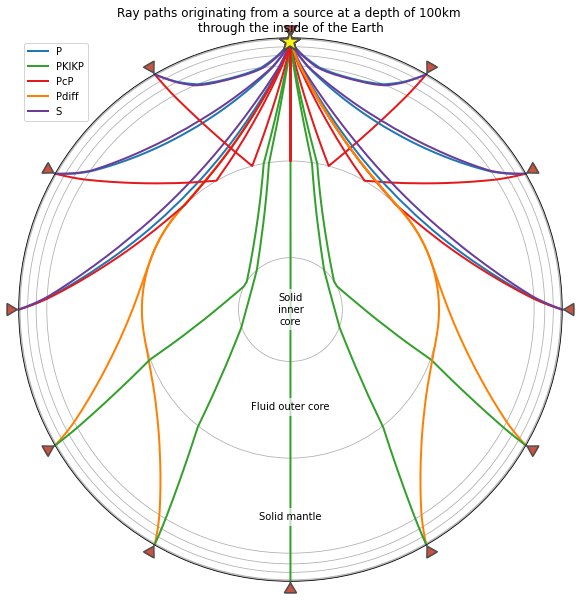

In [12]:
# Select velocity model
model = TauPyModel(model='iasp91')

# Set figure size and axes
fig, ax = plt.subplots(subplot_kw=dict(polar=True), figsize=(10,10))

# Customize plot
ax.set_title('Ray paths originating from a source at a depth of 100km \nthrough the inside of the Earth')
ax.text(0, 0, 'Solid\ninner\ncore',
        horizontalalignment='center', verticalalignment='center',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
ocr = (model.model.radius_of_planet -
       (model.model.s_mod.v_mod.iocb_depth +
        model.model.s_mod.v_mod.cmb_depth) / 2)
ax.text(np.deg2rad(180), ocr, 'Fluid outer core',
        horizontalalignment='center',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
mr = model.model.radius_of_planet - model.model.s_mod.v_mod.cmb_depth / 2
ax.text(np.deg2rad(180), mr, 'Solid mantle',
        horizontalalignment='center',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

# Plot ray paths in a spherical coordinate system
ax = plot_ray_paths(source_depth = 100, phase_list = ['P', 'S', 'Pdiff', 'PKIKP', 'PcP'],
                    npoints =13, legend = True, fig = fig, ax = ax)


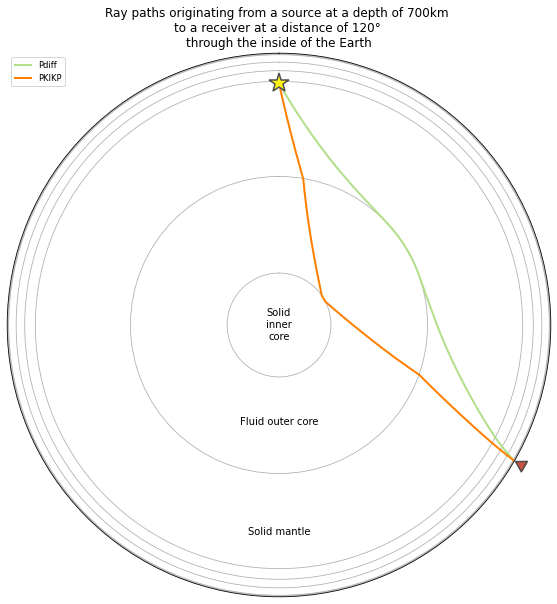

In [13]:
# Set figure size and axes
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1, polar=True)

# Customize plot
ax.set_title('Ray paths originating from a source at a depth of 700km \nto a receiver at a distance of 120° \nthrough the inside of the Earth')
ax.text(0, 0, 'Solid\ninner\ncore',
        horizontalalignment='center', verticalalignment='center',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
ocr = (model.model.radius_of_planet -
       (model.model.s_mod.v_mod.iocb_depth +
        model.model.s_mod.v_mod.cmb_depth) / 2)
ax.text(np.deg2rad(180), ocr, 'Fluid outer core',
        horizontalalignment='center',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
mr = model.model.radius_of_planet - model.model.s_mod.v_mod.cmb_depth / 2
ax.text(np.deg2rad(180), mr, 'Solid mantle',
        horizontalalignment='center',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

# Plot ray paths in a spherical coordinate system
arrivals = model.get_ray_paths(source_depth_in_km=700, distance_in_degree=120,  
                               phase_list = ['P', 'S', 'Pdiff', 'PKIKP', 'PcP'])
arrivals.plot_rays(legend=True, fig=fig, ax=ax)
plt.show()